In [47]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os, sys
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.layers.core import Dense, Flatten
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.layers import RandomRotation, RandomFlip

In [48]:
def convert_tif_or_dmp_to_jpeg(input_dir, out_dir):
    for infile in os.listdir(input_dir):
        print("file : " + infile)
        if infile[-3:] == "tif" or infile[-3:] == "bmp" :
           # print "is tif or bmp"
           outfile = infile[:-3] + "jpeg"
           im = Image.open(os.path.join(input_dir, infile))
           print("new filename : " + outfile)
           out = im.convert("RGB")
           out = out.resize((200, 200))
           out.save(os.path.join(out_dir, outfile), "JPEG", quality=100)

In [85]:
input_data_dir = fr'F:\Dima\dissertation\Data\other_datasets\some_paper\all_data'
output_data_dir = fr'F:\Dima\dissertation\Data\other_datasets\some_paper\all_data\output'
img_height = 200
img_width = 200
batch_size = 20

In [21]:
convert_tif_or_dmp_to_jpeg(os.path.join(input_data_dir, 'Benign'), os.path.join(output_data_dir, fr'Benign'))
convert_tif_or_dmp_to_jpeg(os.path.join(input_data_dir, 'InSitu'), os.path.join(output_data_dir, fr'InSitu'))
convert_tif_or_dmp_to_jpeg(os.path.join(input_data_dir, 'Invasive'), os.path.join(output_data_dir, fr'Invasive'))
convert_tif_or_dmp_to_jpeg(os.path.join(input_data_dir, 'Normal'), os.path.join(output_data_dir, fr'Normal'))

file : b001.tif
new filename : b001.jpeg
file : b002.tif
new filename : b002.jpeg
file : b003.tif
new filename : b003.jpeg
file : b004.tif
new filename : b004.jpeg
file : b005.tif
new filename : b005.jpeg
file : b006.tif
new filename : b006.jpeg
file : b007.tif
new filename : b007.jpeg
file : b008.tif
new filename : b008.jpeg
file : b009.tif
new filename : b009.jpeg
file : b010.tif
new filename : b010.jpeg
file : b011.tif
new filename : b011.jpeg
file : b012.tif
new filename : b012.jpeg
file : b013.tif
new filename : b013.jpeg
file : b014.tif
new filename : b014.jpeg
file : b015.tif
new filename : b015.jpeg
file : b016.tif
new filename : b016.jpeg
file : b017.tif
new filename : b017.jpeg
file : b018.tif
new filename : b018.jpeg
file : b019.tif
new filename : b019.jpeg
file : b020.tif
new filename : b020.jpeg
file : b021.tif
new filename : b021.jpeg
file : b022.tif
new filename : b022.jpeg
file : b023.tif
new filename : b023.jpeg
file : b024.tif
new filename : b024.jpeg
file : b025.tif


In [86]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        output_data_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        label_mode="categorical",
        image_size=(img_height, img_width),
        batch_size=batch_size)
train_ds




Found 400 files belonging to 4 classes.
Using 320 files for training.


<BatchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [87]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    output_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds

Found 400 files belonging to 4 classes.
Using 80 files for validation.


<BatchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [104]:
class_names = train_ds.class_names


AttributeError: 'MapDataset' object has no attribute 'class_names'

In [105]:
class_names

['Benign', 'InSitu', 'Invasive', 'Normal']

In [89]:
data_augmentation = keras.Sequential(
    [
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.1)
    ]
)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [90]:
val_ds = val_ds.map(lambda x, y: (data_augmentation(x), y))

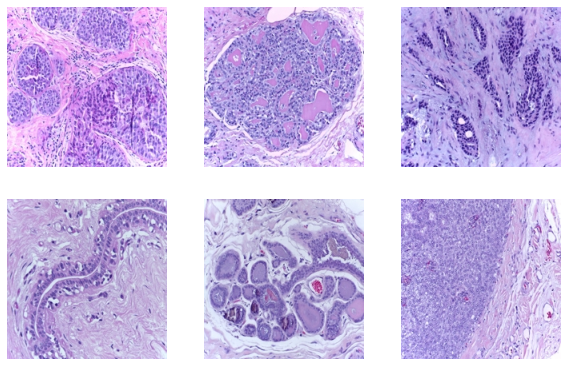

In [91]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")


In [92]:
train_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [93]:
resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(img_height, img_width, 3),
                                                  pooling='avg', classes=len(class_names),
                                                  weights='imagenet')
for layer in pretrained_model.layers:
    layer.trainable = False


In [94]:
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(len(class_names), activation='sigmoid'))

In [95]:
resnet_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 1,051,140
Non-trainable params: 23,587,712
_________________________________________________________________


In [96]:
resnet_model.compile(optimizer=Adam(lr=0.01), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [97]:
history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
16/16 [==============================] - 16s 880ms/step - loss: 10.5222 - accuracy: 0.4000 - val_loss: 2.5971 - val_accuracy: 0.4500
Epoch 2/20
16/16 [==============================] - 13s 837ms/step - loss: 1.1492 - accuracy: 0.5969 - val_loss: 1.1991 - val_accuracy: 0.5875
Epoch 3/20
16/16 [==============================] - 14s 867ms/step - loss: 0.6873 - accuracy: 0.7312 - val_loss: 1.3065 - val_accuracy: 0.5750
Epoch 4/20
16/16 [==============================] - 14s 865ms/step - loss: 0.4760 - accuracy: 0.8062 - val_loss: 0.9452 - val_accuracy: 0.6875
Epoch 5/20
16/16 [==============================] - 14s 872ms/step - loss: 0.3392 - accuracy: 0.8781 - val_loss: 1.0619 - val_accuracy: 0.6875
Epoch 6/20
16/16 [==============================] - 14s 866ms/step - loss: 0.2672 - accuracy: 0.9156 - val_loss: 1.1702 - val_accuracy: 0.6875
Epoch 7/20
16/16 [==============================] - 14s 872ms/step - loss: 0.1912 - accuracy: 0.9594 - val_loss: 1.1582 - val_accuracy: 0.712

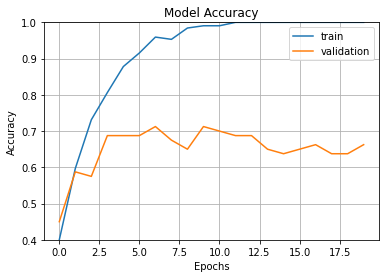

In [98]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [103]:
import cv2
image=cv2.imread(fr'F:\Dima\dissertation\Data\other_datasets\some_paper\all_data\output\b100.jpeg')
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)

pred=resnet_model.predict(image)

output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)
print(pred)

The predicted class is InSitu
[[0.08454132 0.999882   0.00712398 0.8121084 ]]


In [99]:
image = Image.open(fr'F:\Dima\dissertation\Data\other_datasets\some_paper\all_data\n001.jpeg')
print(f"Original size : {image.size}") # 5464x3640

sunset_resized = image.resize((400, 400))
sunset_resized.save('sunset_400.jpeg')

FileNotFoundError: [Errno 2] No such file or directory: 'F:\\Dima\\dissertation\\Data\\other_datasets\\some_paper\\all_data\\n001.jpeg'